<a href="https://colab.research.google.com/github/KravitzLab/KreedLabWiki/blob/main/Photometry_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import libraries
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit, minimize
from scipy.stats import linregress
from scipy.signal import butter, filtfilt

Please upload a CSV file.


Saving 159M5NacPhotometry.csv to 159M5NacPhotometry (3).csv
Uploaded file '159M5NacPhotometry (3).csv' successfully loaded into DataFrame 'dfraw'.


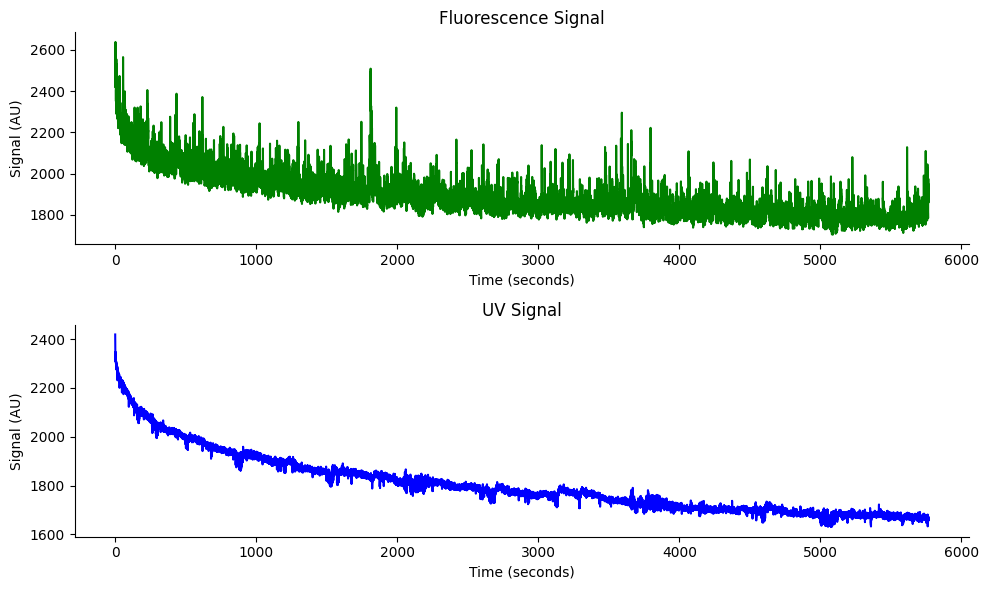

In [14]:
# @title Prompt user to upload a CSV file from RWD system,
print("Please upload a CSV file.")
uploaded = files.upload()

# Load the uploaded CSV file into a DataFrame and adjust TimeStamp column
if uploaded:
    filename = next(iter(uploaded))
    dfraw = None # Initialize dfraw

    # Try reading with header=0 first
    try:
        temp_df = pd.read_csv(filename, header=0)
        if 'Time' in temp_df.columns or 'TimeStamp' in temp_df.columns:
            dfraw = temp_df
    except Exception:
        pass # Ignore errors for now, try next header

    # If dfraw is still None, try reading with header=1
    if dfraw is None:
        try:
            temp_df = pd.read_csv(filename, header=1)
            if 'Time' in temp_df.columns or 'TimeStamp' in temp_df.columns:
                dfraw = temp_df
        except Exception:
            pass # Ignore errors

    if dfraw is not None:
        print(f"Uploaded file '{filename}' successfully loaded into DataFrame 'dfraw'.")

        # Normalize TimeStamp column name
        if 'Time' in dfraw.columns and 'TimeStamp' not in dfraw.columns:
            dfraw.rename(columns={'Time': 'TimeStamp'}, inplace=True)

        # Check if 'TimeStamp' exists after potential renaming
        if 'TimeStamp' in dfraw.columns:
            # Multiply the "TimeStamp" column by 1000 and create TimeStampAdjusted
            dfraw['TimeStampAdjusted'] = dfraw['TimeStamp'] / 1000
        else:
            print("Warning: 'TimeStamp' column not found after header detection and renaming. 'TimeStampAdjusted' cannot be created.")

        # Rename columns: "CH1-410" to "UV" and "CH1-470" to "Fluorescence"
        column_mapping = {}
        if 'CH1-410' in dfraw.columns:
            column_mapping['CH1-410'] = 'UV'
        if 'CH1-470' in dfraw.columns:
            column_mapping['CH1-470'] = 'Fluorescence'
        dfraw.rename(columns=column_mapping, inplace=True)

        # Drop any column that contains 'Unnamed' in its column name
        dfraw = dfraw.loc[:, ~dfraw.columns.str.contains('^Unnamed', regex=True)]
    else:
        print("Error: Could not load the CSV file. Neither 'Time' nor 'TimeStamp' column found in header row 0 or 1.")
        dfraw = pd.DataFrame() # Ensure dfraw is defined as an empty DataFrame to prevent downstream errors.

else:
    print("No file uploaded.")

#create a new copy to work with (we can go back to this step if we need to without re-importing the .csv file)
df = dfraw.copy()

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'Fluorescence'
axs[0].plot(df['TimeStampAdjusted'], df['Fluorescence'], 'g', label='Fluorescence')
axs[0].set_title('Fluorescence Signal')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal (AU)')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Second subplot for 'UV'
axs[1].plot(df['TimeStampAdjusted'], df['UV'], 'b', label='UV')
axs[1].set_title('UV Signal')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Signal (AU)')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

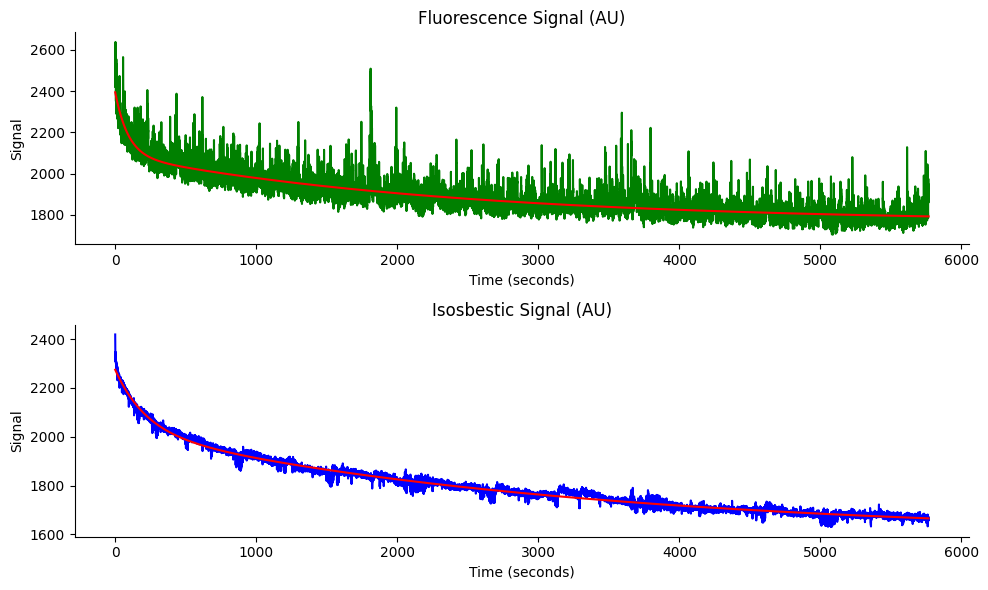

In [15]:
# @title Fit exponential to both isosbestic and fluorescence

def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset.
    amp_fast: Amplitude of the fast component.
    amp_slow: Amplitude of the slow component.
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow.
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

#Fit curve to Fluorescence signal
max_sig = np.max(df['Fluorescence'])
#set boundaries for how much of the traces to use for curve fitting
bounds = ([0      , 0      , 0      , 0  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
inital_params = [max_sig/2, max_sig/4, max_sig/4, 7500, 0.1]
time_seconds = df['TimeStampAdjusted']
raw_Fluorescence = df['Fluorescence']
Fluorescence_params, param_cov = curve_fit(double_exponential, time_seconds, raw_Fluorescence,
                                  p0=inital_params, bounds=bounds, maxfev=1000)
Fluorescence_expfit = double_exponential(time_seconds, *Fluorescence_params)

#Fit curve to iso signal
max_sig = np.max(df['UV'])
#set boundaries for how much of the traces to use for curve fitting
bounds = ([0      , 0      , 0      , 0  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
inital_params = [max_sig/2, max_sig/4, max_sig/4, 7500, 0.1]
raw_iso = df['UV']
iso_params, param_cov = curve_fit(double_exponential, time_seconds, raw_iso,
                                  p0=inital_params, bounds=bounds, maxfev=1000)
iso_expfit = double_exponential(time_seconds, *iso_params)

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'Fluorescence'
axs[0].plot(time_seconds, raw_Fluorescence, 'g', label='Fluorescence')
axs[0].plot(time_seconds, Fluorescence_expfit, 'r', label='Fluorescence')
axs[0].set_title('Fluorescence Signal (AU)')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# First subplot for 'Fluorescence'
axs[1].plot(time_seconds, raw_iso, 'b', label='Iso')
axs[1].plot(time_seconds, iso_expfit, 'r', label='Iso')
axs[1].set_title('Isosbestic Signal (AU)')  # Set title for the first subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[1].set_ylabel('Signal')  # Set y-axis label for the first subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

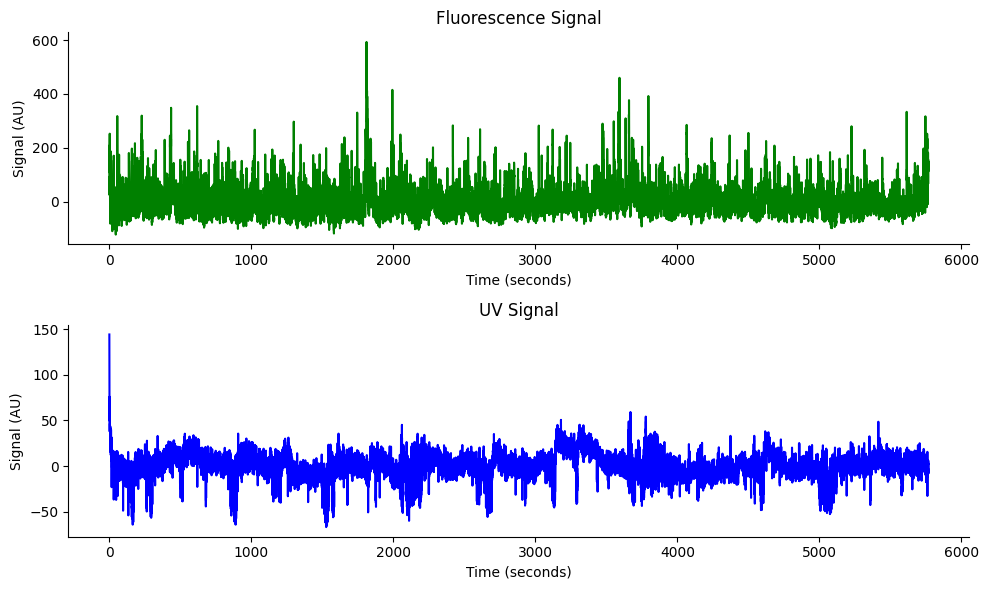

In [16]:
# @title Debleach by substracting fitted exponentials from raw curves

Fluorescence_debleached = raw_Fluorescence - Fluorescence_expfit
iso_debleached = raw_iso - iso_expfit

# Initialize a figure with 2 subplots, arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # 'figsize' is optional, adjust it as needed

# First subplot for 'Fluorescence'
axs[0].plot(time_seconds, Fluorescence_debleached, 'g', label='Fluorescence')
axs[0].set_title('Fluorescence Signal')  # Set title for the first subplot
axs[0].set_xlabel('Time (seconds)')  # Set x-axis label for the first subplot
axs[0].set_ylabel('Signal (AU)')  # Set y-axis label for the first subplot
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Second subplot for 'UV'
axs[1].plot(time_seconds, iso_debleached, 'b', label='UV')
axs[1].set_title('UV Signal')  # Set title for the second subplot
axs[1].set_xlabel('Time (seconds)')  # Set x-axis label for the second subplot
axs[1].set_ylabel('Signal (AU)')  # Set y-axis label for the second subplot
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

Correlation coefficient (r): 0.0331
Slope: 0.1373, Intercept: 0.0000


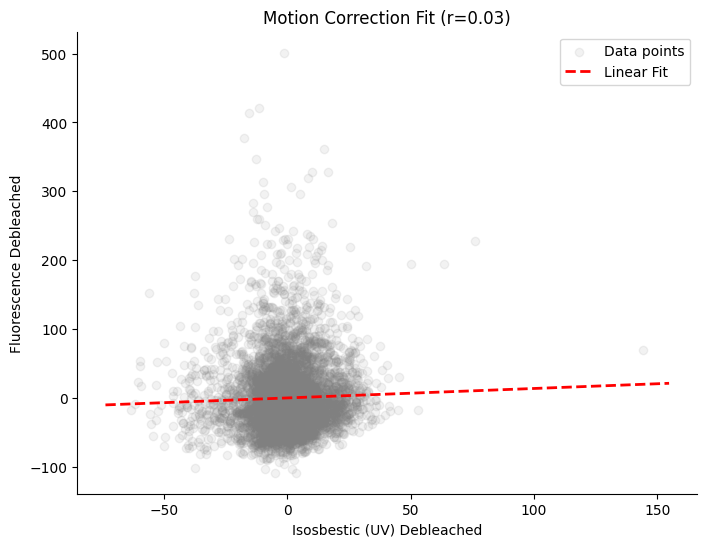

In [18]:
# @title Calculate motion correction using Linear Regression

# Perform linear regression to find the relationship between the isosbestic (UV) and fluorescence signals
# We assume the UV signal represents motion artifacts that are also present in the fluorescence channel
slope, intercept, r_value, p_value, std_err = linregress(x=iso_debleached, y=Fluorescence_debleached)

print(f"Correlation coefficient (r): {r_value:.4f}")
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")

# Calculate the estimated motion component in the fluorescence signal
est_motion = intercept + slope * iso_debleached

# Subtract the estimated motion from the fluorescence signal to get the corrected signal
Fluorescence_corrected = Fluorescence_debleached - est_motion

# --- Plotting Correlation ---
plt.figure(figsize=(8, 6))
# Plot a subset of points for performance/clarity if the dataset is large
subset_idx = np.arange(0, len(Fluorescence_debleached), 10)
plt.scatter(iso_debleached.iloc[subset_idx], Fluorescence_debleached.iloc[subset_idx],
            alpha=0.1, color='gray', label='Data points')

# Plot the regression line
x_vals = np.array(plt.xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, 'r--', linewidth=2, label='Linear Fit')

plt.title(f'Motion Correction Fit (r={r_value:.2f})')
plt.xlabel('Isosbestic (UV) Debleached')
plt.ylabel('Fluorescence Debleached')
plt.legend()
sns.despine()
plt.show()

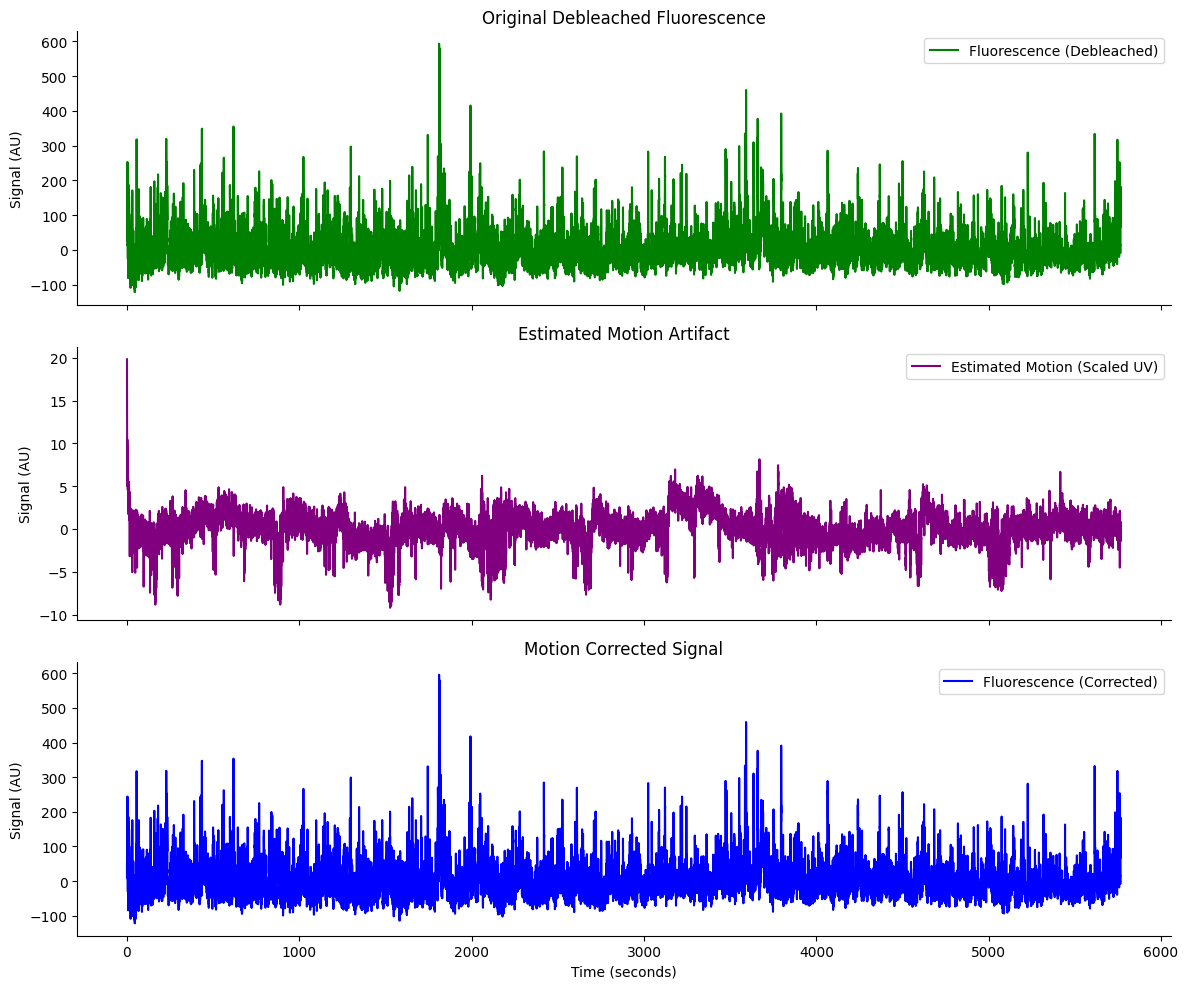

In [19]:
# @title Visualize Motion Correction Results

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Debleached Fluorescence
axs[0].plot(time_seconds, Fluorescence_debleached, 'g', label='Fluorescence (Debleached)')
axs[0].set_title('Original Debleached Fluorescence')
axs[0].set_ylabel('Signal (AU)')
axs[0].legend(loc='upper right')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# 2. Estimated Motion (Scaled UV)
axs[1].plot(time_seconds, est_motion, 'purple', label='Estimated Motion (Scaled UV)')
axs[1].set_title('Estimated Motion Artifact')
axs[1].set_ylabel('Signal (AU)')
axs[1].legend(loc='upper right')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# 3. Motion Corrected Signal
axs[2].plot(time_seconds, Fluorescence_corrected, 'b', label='Fluorescence (Corrected)')
axs[2].set_title('Motion Corrected Signal')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Signal (AU)')
axs[2].legend(loc='upper right')
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

In [20]:
# @title Save and Download Processed Data

# Add processed data as new columns to the DataFrame
df['Debleached Fluorescence'] = Fluorescence_debleached
df['Debleached UV'] = iso_debleached
df['Estimated Motion'] = est_motion
df['CorrectedFluorescence'] = Fluorescence_corrected

# Calculate Z-score for CorrectedFluorescence
df['CorrectedFluorescence_Z'] = (df['CorrectedFluorescence'] - df['CorrectedFluorescence'].mean()) / df['CorrectedFluorescence'].std()

# Generate a new filename
if 'filename' in locals():
    base_name = filename.rsplit('.', 1)[0]
    new_filename = f"{base_name}_processed.csv"
else:
    new_filename = "processed_photometry_data.csv"

# Save the DataFrame to a CSV file
df.to_csv(new_filename, index=False)
print(f"Processed file saved as '{new_filename}'.")

# Download the file
files.download(new_filename)

Processed file saved as '159M5NacPhotometry (3)_processed.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>